<a href="https://colab.research.google.com/github/Maternowsky/Maternowsky/blob/main/CNN_for_SMILE_DataAugmentation%2C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CNN for Smile Classification**

# **Loading the CelebA dataset**

In [2]:
from numpy.core.arrayprint import format_float_scientific
import torch
import torchvision
from torchvision import datasets, transforms
import numpy as np
import torch.nn as nn

image_path = './'
celeba_train_dataset = torchvision.datasets.CelebA(image_path,
                                                  split = 'train',
                                                  target_type = 'attr',
                                                  download = True)
celeba_valid_dataset = torchvision.datasets.CelebA(image_path,
                                                  split = 'valid',
                                                  target_type = 'attr',
                                                  download = True)
celeba_test_dataset = torchvision.datasets.CelebA(image_path,
                                                 split = 'test',
                                                 target_type  = 'attr',
                                                 download = True)
print('Train set: ', len(celeba_train_dataset))
print('Valid set: ', len(celeba_valid_dataset))
print('Test set: ', len(celeba_test_dataset))

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Train set:  162770
Valid set:  19867
Test set:  19962


# **Data Augmentation for boosting performance of deep NN's**

# Data augmentation is not only for image data. There is a set of transformations unique to image data such as cropping parts of the image, flipping, and changing contrast, brightness, and saturation. som transformations available via the 'torochvision.transforms' module



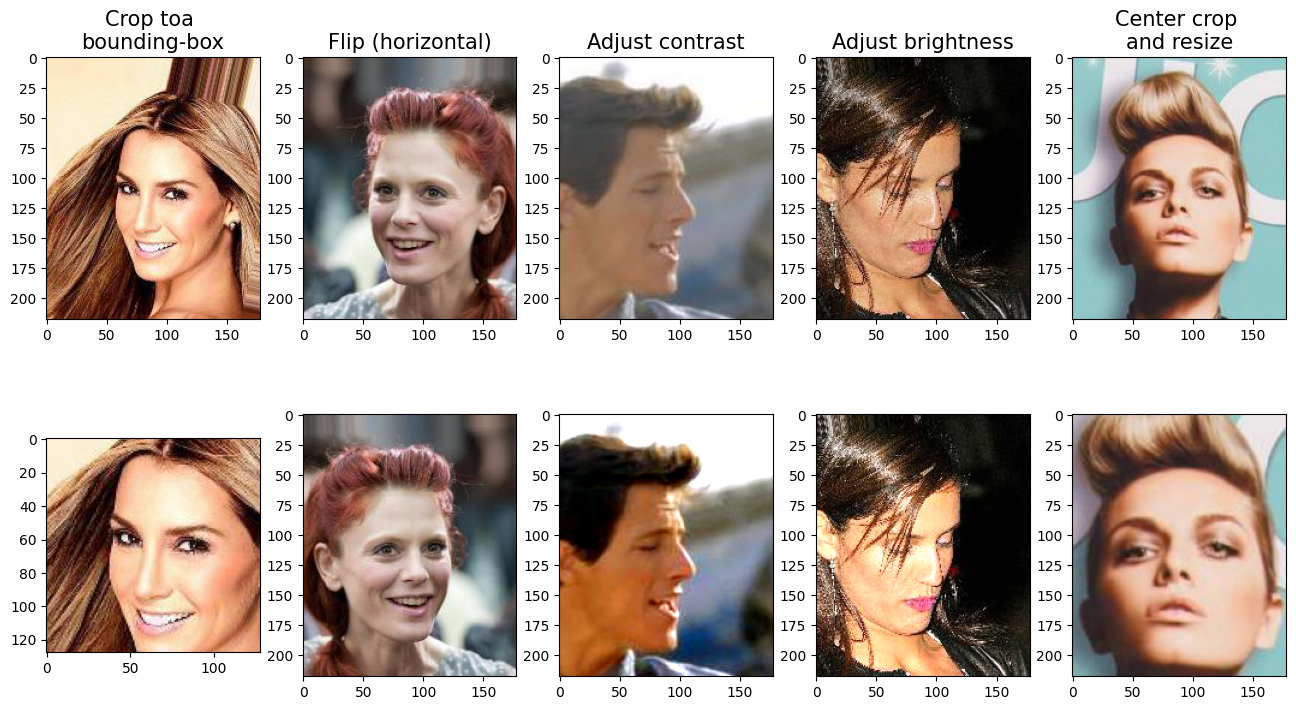

In [7]:
import matplotlib.pyplot as plt


fig = plt.figure(figsize=(16, 8.5))

## Column 1: cropping to a bounding-box
ax = fig.add_subplot(2,5,1)
img, attr = celeba_train_dataset[0]
ax.set_title('Crop toa \nbounding-box', size = 15)
ax.imshow(img)

ax = fig.add_subplot(2,5,6)
img_cropped = transforms.functional.crop(img, 50, 20, 128, 128)
ax.imshow(img_cropped)

## Column 2: flipping (horizontally)
ax = fig.add_subplot(2,5,2)
img, attr = celeba_train_dataset[1]
ax.set_title('Flip (horizontal)', size = 15)
ax.imshow(img)

ax = fig.add_subplot(2, 5, 7)
img_flipped = transforms.functional.hflip(img)
ax.imshow(img_flipped)

## Column 3: adjust contrast
ax = fig.add_subplot(2,5,3)
img, attr = celeba_train_dataset[2]
ax.set_title('Adjust contrast', size = 15)
ax.imshow(img)

ax = fig.add_subplot(2, 5, 8)
img_adj_contrast = transforms.functional.adjust_contrast(img, contrast_factor = 2)
ax.imshow(img_adj_contrast)

## Column 4: adjust brightness
ax = fig.add_subplot(2,5,4)
img, attr = celeba_train_dataset[3]
ax.set_title('Adjust brightness', size = 15)
ax.imshow(img)

ax = fig.add_subplot(2,5,9)
img_adj_brightness = transforms.functional.adjust_brightness(img, brightness_factor = 1.3)
ax.imshow(img_adj_brightness)

# Column 5: cropping from image center
ax = fig.add_subplot(2,5,5)
img, attr = celeba_train_dataset[4]
ax.set_title('Center crop \nand resize', size=15)
ax.imshow(img)
ax= fig.add_subplot(2,5,10)
img_center_crop = transforms.functional.center_crop(img, [0.7*218, 0.7*178])
img_resized = transforms.functional.resize(img_center_crop, size=(218, 178))
ax.imshow(img_resized)
plt.show()



## **Can set augmentation of features randomly. for example, we can first randomly crop and image, then flip it randomly, and finally resize it to desired size. code is as follows**

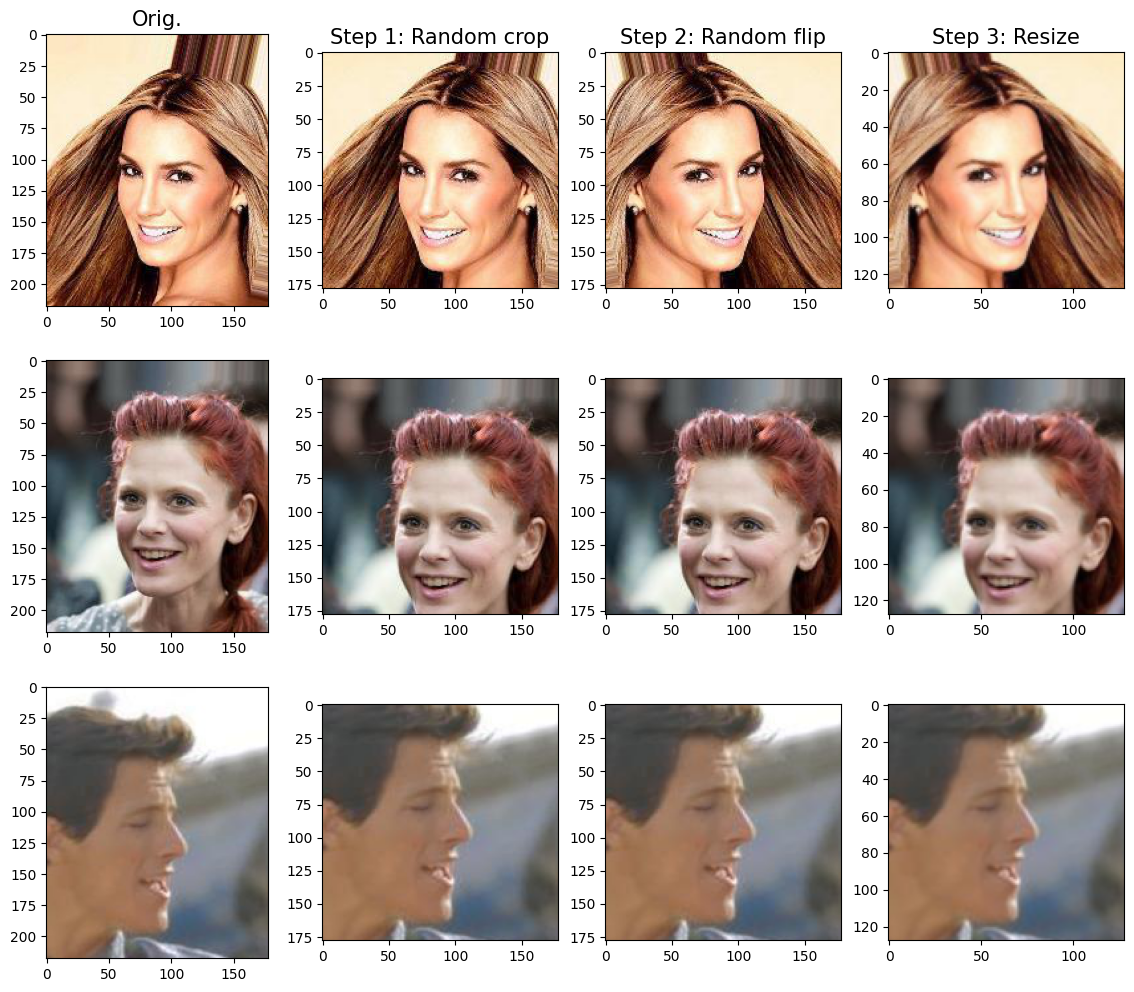

In [9]:
torch.manual_seed(1)
fig = plt.figure(figsize=(14,12))
for i, (img, attr) in enumerate(celeba_train_dataset):
  ax = fig.add_subplot(3, 4, i*4+1)
  ax.imshow(img)
  if i ==0:
    ax.set_title('Orig.', size=15)
  ax = fig.add_subplot(3, 4, i*4+2)
  img_transform = transforms.Compose([transforms.RandomCrop([178, 178])])
  img_cropped = img_transform(img)
  ax.imshow(img_cropped)
  if i == 0:
    ax.set_title('Step 1: Random crop', size = 15)
  ax = fig.add_subplot(3, 4, i*4+3)
  img_transform = transforms.Compose([transforms.RandomHorizontalFlip()])
  img_flip = img_transform(img_cropped)
  ax.imshow(img_flip)
  if i == 0:
    ax.set_title('Step 2: Random flip', size = 15)
  ax = fig.add_subplot(3, 4, i*4+4)
  img_resized = transforms.functional.resize( img_flip, size = (128,128))
  ax.imshow(img_resized)
  if i == 0:
    ax.set_title('Step 3: Resize', size = 15)
  if i == 2:
    break

plt.show()

### **Can define transform functions to use the pipeline for data augmentation during the dataset loading. below we define get_smile, which will etract the smile label from the 'attributes' list**

In [10]:
get_smile = lambda attr: attr[31]

## **Define transform_train function that will randomly crop, flip randomly, and resize to 64x64**

In [11]:
transform_train = transforms.Compose([transforms.RandomCrop([178, 178]),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.Resize([64,64]),
                                      transforms.ToTensor(),])

### **Only apply data augmentation to the training examples and not to validation or test**

In [12]:
transform = transforms.Compose([transforms.CenterCrop([178,178]),
                                transforms.Resize([64, 64]),
                                transforms.ToTensor(),])

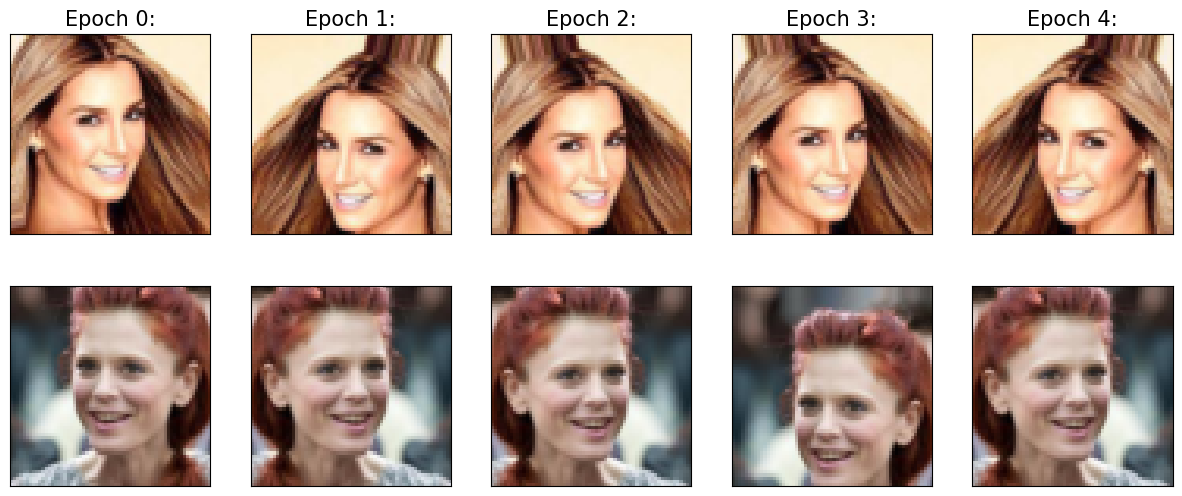

In [13]:
from torch.utils.data import DataLoader
celeba_train_dataset = torchvision.datasets.CelebA( image_path,
                                                   split = 'train',
                                                    target_type = 'attr',
                                                    download = False,
                                                    transform = transform_train,
                                                    target_transform = get_smile)
torch.manual_seed(1)
data_loader = DataLoader(celeba_train_dataset, batch_size = 2)
fig = plt.figure(figsize=(15, 6))
num_epochs = 5
for j in range(num_epochs):
  img_batch, label_batch = next(iter(data_loader))
  img = img_batch[0]
  ax = fig.add_subplot(2, 5, j+1)
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_title(f'Epoch {j}:', size = 15)
  ax.imshow(img.permute(1,2,0))
  img = img_batch[1]
  ax = fig.add_subplot(2, 5, j+6)
  ax.set_xticks([])
  ax.set_yticks([])
  ax.imshow(img.permute(1,2,0))

plt.show()

## **Apply transform to validation and test datasets**

In [14]:
celeba_valid_dataset = torchvision.datasets.CelebA(image_path,
                                                   split = 'valid',
                                                   target_type = 'attr',
                                                   download = False,
                                                   transform = transform,
                                                   target_transform = get_smile)
celeba_test_dataset = torchvision.datasets.CelebA(image_path,
                                                  split = 'test',
                                                  target_type = 'attr',
                                                  download = False,
                                                  transform = transform,
                                                  target_transform = get_smile)

## **Instead of using all training and validation data we will take a subset of 16000 training and 1000 for validation. goal is to intentionally train our model with small dataset**

In [16]:
from torch.utils.data import Subset
celeba_train_dataset = Subset(celeba_train_dataset, torch.arange(16000))
celeba_valid_dataset = Subset(celeba_valid_dataset, torch.arange(1000))
print('Train set:', len(celeba_train_dataset) , '\nValidation set:',
                        len(celeba_valid_dataset))

Train set: 16000 
Validation set: 1000


### **create dataloaders for three datasets**

In [17]:
batch_size = 32
torch.manual_seed(1)
train_dl = DataLoader(celeba_train_dataset,
                      batch_size, shuffle=True)
valid_dl = DataLoader(celeba_valid_dataset,
                      batch_size, shuffle = False)
test_dl = DataLoader(celeba_test_dataset,
                     batch_size, shuffle = False)

# **Train a CNN smile classifier- building model with torch.nn module**

In [18]:
model = nn.Sequential()
model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels = 32,
                                    kernel_size=3, padding=1))
model.add_module('relu1', nn.ReLU())
model.add_module('pool1', nn.MaxPool2d(kernel_size = 2))
model.add_module('dropout1', nn.Dropout(p=0.5))

model.add_module('conv2', nn.Conv2d(in_channels=32, out_channels = 64,
                                    kernel_size = 3, padding=1))
model.add_module('relu2', nn.ReLU())
model.add_module('pool2', nn.MaxPool2d(kernel_size = 2))
model.add_module('dropout2', nn.Dropout(p=0.5))

model.add_module('conv3', nn.Conv2d(in_channels=64, out_channels = 128,
                                    kernel_size = 3, padding=1))
model.add_module('relu3', nn.ReLU())
model.add_module('pool3', nn.MaxPool2d(kernel_size = 2))

model.add_module('conv4', nn.Conv2d(in_channels=128, out_channels = 256,
                                    kernel_size = 3, padding=1))
model.add_module('relu4', nn.ReLU())


In [19]:
# see shape of output feature maps

x = torch.ones((4, 3, 64, 64))
model(x).shape

torch.Size([4, 256, 8, 8])

## **Add fully connected layer to get to the output layer with a single unit. If we flatten the feature maps, the number of input units to this fully connected layer will be 8x8x256 = 16384. Alternately can consider new layer, called 'global-average-pooling, which computes the average of each feature map seperately therefore reducing the hidden units to 256. Then add fully connected layer**

In [20]:
model.add_module('pool4', nn.AvgPool2d(kernel_size = 8))
model.add_module('flatten', nn.Flatten())
x = torch.ones((4,3,64,64))
model(x).shape

torch.Size([4, 256])

In [21]:
# adding fully connected layer to get single output

model.add_module('fc', nn.Linear(256, 1))
model.add_module('sigmoid', nn.Sigmoid())
x = torch.ones((4,3,64,64))
model(x).shape

torch.Size([4, 1])

In [22]:
model

Sequential(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.5, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU()
  (pool4): AvgPool2d(kernel_size=8, stride=8, padding=0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

## **Create loss function and optimizer, create train model function**

In [24]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

def train(model, num_epochs, train_dl, valid_dl):
  loss_hist_train = [0] * num_epochs
  accuracy_hist_train = [0] * num_epochs
  loss_hist_valid = [0] * num_epochs
  accuracy_hist_valid = [0] * num_epochs
  for epoch in range(num_epochs):
    model.train()
    for x_batch, y_batch in train_dl:
      pred = model(x_batch)[:, 0]
      loss = loss_fn(pred, y_batch.float())
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      loss_hist_train[epoch] += loss.item()*y_batch.size(0)
      is_correct = ((pred>0.5).float() == y_batch).float()
      accuracy_hist_train[epoch] += is_correct.sum()
    loss_hist_train[epoch] /= len(train_dl.dataset)
    accuracy_hist_train[epoch] /= len(train_dl.dataset)
    model.eval()
    with torch.no_grad():
      for x_batch, y_batch in valid_dl:
        pred = model(x_batch)[:, 0]
        loss = loss_fn(pred, y_batch.float())
        loss_hist_valid[epoch] += loss.item()*y_batch.size(0)
        is_correct = ((pred>=0.5).float() == y_batch).float()
        accuracy_hist_valid[epoch] += is_correct.sum().cpu()

    loss_hist_valid[epoch] /= len(valid_dl.dataset)
    accuracy_hist_valid[epoch] /= len(valid_dl.dataset)

    print(f'Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f} val_accuracy: {accuracy_hist_valid[epoch]:.4f}')
  return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

torch.manual_seed(1)
num_epochs = 30
hist = train(model, num_epochs, train_dl, valid_dl)

Epoch 1 accuracy: 0.5268 val_accuracy: 0.5490
Epoch 2 accuracy: 0.5742 val_accuracy: 0.6090
Epoch 3 accuracy: 0.6025 val_accuracy: 0.5440
Epoch 4 accuracy: 0.6261 val_accuracy: 0.6350
Epoch 5 accuracy: 0.6457 val_accuracy: 0.6670
Epoch 6 accuracy: 0.6551 val_accuracy: 0.6790
Epoch 7 accuracy: 0.6712 val_accuracy: 0.6460
Epoch 8 accuracy: 0.6844 val_accuracy: 0.6760
Epoch 9 accuracy: 0.6943 val_accuracy: 0.6830
Epoch 10 accuracy: 0.7210 val_accuracy: 0.6970
Epoch 11 accuracy: 0.7442 val_accuracy: 0.7660
Epoch 12 accuracy: 0.7749 val_accuracy: 0.7980
Epoch 13 accuracy: 0.7920 val_accuracy: 0.7830
Epoch 14 accuracy: 0.8114 val_accuracy: 0.8460
Epoch 15 accuracy: 0.8278 val_accuracy: 0.8700
Epoch 16 accuracy: 0.8357 val_accuracy: 0.8630
Epoch 17 accuracy: 0.8438 val_accuracy: 0.8750
Epoch 18 accuracy: 0.8502 val_accuracy: 0.8690
Epoch 19 accuracy: 0.8531 val_accuracy: 0.8720
Epoch 20 accuracy: 0.8560 val_accuracy: 0.8650
Epoch 21 accuracy: 0.8619 val_accuracy: 0.8820
Epoch 22 accuracy: 0.8

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [28]:
import torch
path = '/content/drive/MyDrive/MLmodels/CNNsmile.pt'

torch.save(hist, path)

In [30]:
model_load = torch.load(path)
model_load

([0.6900264239311218,
  0.676268490433693,
  0.6611578150987625,
  0.646000815987587,
  0.6311942398548126,
  0.6217542966604233,
  0.6058895364403725,
  0.5971089495420456,
  0.5804346024394035,
  0.5533321830034256,
  0.5198340967893601,
  0.4698350589871407,
  0.4437439269423485,
  0.40943344309926033,
  0.3847526796758175,
  0.36959564238786696,
  0.35458567015826703,
  0.3432508518993855,
  0.33337683425843717,
  0.32709872630238535,
  0.31925258673727513,
  0.31449741414189336,
  0.3131060523241758,
  0.30636140310764315,
  0.3001430729329586,
  0.2956064686775208,
  0.2910335541367531,
  0.28939538246393204,
  0.28148916412889957,
  0.2805195787549019],
 [0.6855215406417847,
  0.6658856539726258,
  0.6915230059623718,
  0.6427456841468812,
  0.6309459595680237,
  0.6150382876396179,
  0.6087490286827087,
  0.5945159707069397,
  0.5745367813110351,
  0.5592088189125061,
  0.47530811905860904,
  0.4308299512863159,
  0.4286685407161713,
  0.34764316606521606,
  0.30640372037887575

# **Visualize the Learning Curve, compare the training and validation loss and accuracies after each epoch**

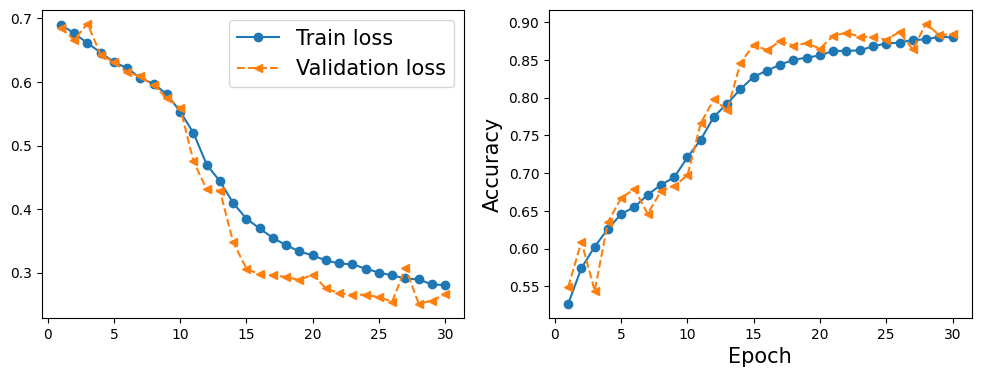

In [31]:
x_arr = np.arange(len(hist[0]))+1
fig = plt.figure(figsize = (12, 4))
ax = fig.add_subplot(1,2,1)
ax.plot(x_arr, hist[0], '-o', label = 'Train loss')
ax.plot(x_arr, hist[1], '--<', label = 'Validation loss')
ax.legend(fontsize = 15)
ax = fig.add_subplot(1,2,2)
ax.plot(x_arr, hist[2], '-o', label = 'Train acc.')
ax.plot(x_arr, hist[3], '--<', label = 'Validation acc.')
ax.set_xlabel('Epoch', size = 15)
ax.set_ylabel('Accuracy', size = 15)
plt.show()

## **Once we are happy with the learning curves, we can evalutate the model on hold-out test dataset**

In [32]:
accuracy_test = 0
model.eval()
with torch.no_grad():
  for x_batch, y_batch in test_dl:
    pred = model(x_batch)[:, 0]
    is_correct = ((pred>= 0.5).float() == y_batch).float()
    accuracy_test += is_correct.sum()

accuracy_test /= len(test_dl.dataset)
print(f'Test accuracy: {accuracy_test:.4f}')

Test accuracy: 0.8963


### **Take a small subset of 10 examples from last batch of test dataset(test_dl). Compute the probabilities of each example from class 1 and visualize the examples along the ground truth label and predicted probabilities**

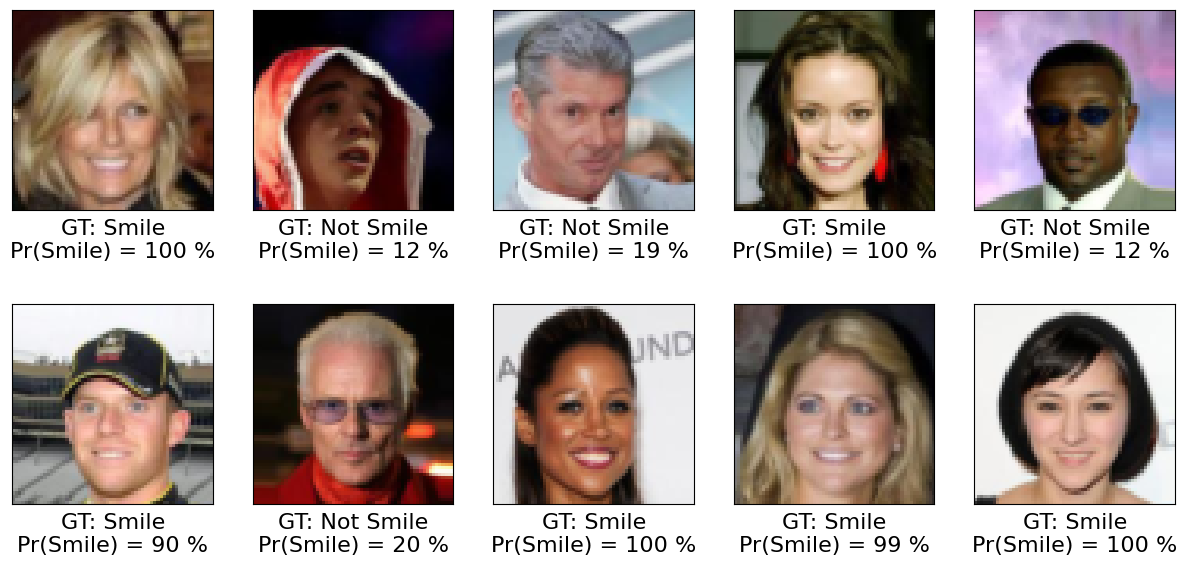

In [34]:
pred = model(x_batch)[:, 0] * 100
fig = plt.figure(figsize = (15, 7))
for j in range(10, 20):
  ax = fig.add_subplot(2,5, j-10+1)
  ax.set_xticks([]); ax.set_yticks([])
  ax.imshow(x_batch[j].permute(1,2,0))
  if y_batch[j] ==1:
    label = 'Smile'
  else:
    label = 'Not Smile'
  ax.text(0.5, -0.15,
          f'GT: {label:s}\nPr(Smile) = {pred[j]:.0f} %',
          size = 16,
          horizontalalignment = 'center',
          verticalalignment = 'center',
          transform = ax.transAxes)
plt.show()